### Notebook to prototype REDCap API calls

In [31]:
import pandas as pd
import numpy as np
import requests
import json
import nipoppy.workflow.logger as my_logger
import seaborn as sns

In [2]:
def api_call(url, query, logger):
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    logger.info(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        logger.error(f"RedCap API request Failed with HTTP Status: {http_status}")

    return query_df

In [3]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "Sept_2023"
current_nipoppy_manifest_csv = f"{release_dir}{current_release}/tabular/manifest.csv"

# log
log_dir = f"{DATASET_ROOT}/scratch/logs/"
log_file = f"{log_dir}/bids_conv.log"
logger = my_logger.get_logger(log_file)

# Available queires (i.e. redcap reports)
# redcap_reports = ["QPN participants", "External QPN (June 2021)", "MoCA-MDS-UPDRS part 3", "Victoria - Weston Project",
#                   "MotorAndNon-Motor"]

### Manifest

In [4]:
visit_list = ["MRI_v1"] 
session_id_list = ["01"]
session_list = [f"ses-{idx}" for idx in session_id_list]

manifest_cols = ["participant_id", "visit", "session"]

current_nipoppy_manifest_df = pd.read_csv(current_nipoppy_manifest_csv)
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["visit"].isin(visit_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["session"].isin(session_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[manifest_cols]
nipoppy_participants = current_nipoppy_manifest_df["participant_id"].unique()
nipoppy_participants = [p.upper() for p in nipoppy_participants]
n_participants = len(nipoppy_participants)
print(f"n_participants: {n_participants}")
current_nipoppy_manifest_df.head()

n_participants: 265


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


### Redcap config

In [5]:
redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
redcap_config = json.load(open(redcap_config_json))
url = redcap_config["url"]
redcap_reports = list(redcap_config["queries"].keys())
n_redcap_reports = len(redcap_reports)
logger.info(f"redcap_reports ({n_redcap_reports}): {redcap_reports}")

2023-10-25 22:17:02,880 - nipoppy.workflow.logger - INFO - redcap_reports (8): ['QPN participants', 'External QPN (June 2021)', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']


In [6]:
query_dict = {}
redcap_participants = []
for query_label in redcap_reports:
    query = redcap_config["queries"][query_label]

    # run query
    logger.info(f"Running query {query_label}...")
    query_df = api_call(url, query, logger=logger)

    # get the list of participants
    _participants = query_df["record_id"].unique()
    redcap_participants.extend(_participants)
    n_participants = len(redcap_participants)

    # get the list of redcap events
    redcap_events = query_df["redcap_event_name"].unique()
    n_events = len(redcap_events)

    logger.info(f"Fetched {n_participants} participants and {n_events} event_ids: {redcap_events}")

    query_dict[query_label] = query_df.copy()

2023-10-25 22:17:04,654 - nipoppy.workflow.logger - INFO - Running query QPN participants...
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2023-10-25 22:17:06,045 - nipoppy.workflow.logger - INFO - HTTP Status: 200
2023-10-25 22:17:06,054 - nipoppy.workflow.logger - INFO - Fetched 264 participants and 7 event_ids: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '60 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']
2023-10-25 22:17:06,058 - nipoppy.workflow.logger - INFO - Running query External QPN (June 2

In [7]:
redcap_participants = [p.upper() for p in redcap_participants]

a = set(redcap_participants)
b = set(nipoppy_participants)

common_participants = a.intersection(b)
n_common_participants = len(common_participants)
new_redcap_participants  = a.difference(b)
n_new_redcap_participants = len(new_redcap_participants)
new_nipoppy_participants  = b.difference(a)
n_new_nipoppy_participants = len(new_nipoppy_participants)

logger.info(f"Found {n_common_participants} common participants")
logger.info(f"Found {n_new_redcap_participants} new redcap participants")
logger.info(f"Found {n_new_nipoppy_participants} new nipoppy participants")

2023-10-25 22:17:19,464 - nipoppy.workflow.logger - INFO - Found 256 common participants
2023-10-25 22:17:19,466 - nipoppy.workflow.logger - INFO - Found 1064 new redcap participants
2023-10-25 22:17:19,469 - nipoppy.workflow.logger - INFO - Found 9 new nipoppy participants


### Demographics and summary clinical scores

- `MotorAndNon-Motor` has demographics (age, gender) and summary clinical scores (updrs, moca)
    - verify moca column with extra point i.e. `moca_extra_point`
- `Diagnosis QPN` has Dx for all participants

In [18]:
query_df = query_dict['MotorAndNon-Motor']
query_df = query_df[query_df["record_id"].isin(common_participants)]
print(len(query_df))
query_df.head()

368


,record_id,redcap_event_name,method_questionnaire,study_visit_age,gender,updrs_method,updrs_rater,updrs_1_1,eq1_1,updrs_1_2,...,moca_result_4,moca_result_5,moca_result_6,moca_result_7,moca_result_8,moca_result_9,moca_result,moca_calculation,moca_extra_point,moca_complete
122,MNI0056,Baseline (Arm 1: C-OPN),Online/En ligne,79,Male/Masculin,In-person/En personne,Patient,0: Normal: No cognitive impairment.,0,0: Normal: No hallucinations or psychotic beha...,...,No points/Pas de point,4,1,2,3,6,22,21,Yes/Oui,Complete
124,MNI0058,Baseline (Arm 1: C-OPN),Online/En ligne,57,Male/Masculin,In-person/En personne,Patient,0: Normal: No cognitive impairment.,0,0: Normal: No hallucinations or psychotic beha...,...,No points/Pas de point,5,2,0,4,6,25,24,Yes/Oui,Complete
129,MNI0068,Baseline (Arm 1: C-OPN),Online/En ligne,69,Male/Masculin,In-person/En personne,Patient and Caregiver in Equal Proportion,2: Mild: Clinically evident cognitive dysfunct...,2,0: Normal: No hallucinations or psychotic beha...,...,,,,,,,,,,Incomplete
134,MNI0079,Baseline (Arm 1: C-OPN),Online/En ligne,49,Female/Féminin,In-person/En personne,Patient,0: Normal: No cognitive impairment.,0,0: Normal: No hallucinations or psychotic beha...,...,No points/Pas de point,5,3,2,5,6,26,26,No/Non,Complete
135,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),,,,,,,,,...,,,,,,,,,,Incomplete


In [9]:
query_df = query_dict['QPN sex']
query_df = query_df[query_df["record_id"].isin(common_participants)]
print(len(query_df))
query_df.head()

368


,record_id,redcap_event_name,gender
122,MNI0056,Baseline (Arm 1: C-OPN),Male/Masculin
124,MNI0058,Baseline (Arm 1: C-OPN),Male/Masculin
129,MNI0068,Baseline (Arm 1: C-OPN),Male/Masculin
134,MNI0079,Baseline (Arm 1: C-OPN),Female/Féminin
135,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),


In [10]:
query_df = query_dict['Diagnosis QPN']
query_df = query_df[query_df["record_id"].isin(common_participants)]
print(len(query_df))
query_df.head()

358


,record_id,redcap_event_name,study_status_v2,diagnosis_determined,diagnosis_pd,diagnosis_pdplus,diagnosis_probability,diagnosis_confirmation
107,MNI0056,Baseline (Arm 1: C-OPN),Enrolled/Inscrit,,Uncertain/Incertain,,50-89% (likely/probable),Patient chart/dossier médical
108,MNI0058,Baseline (Arm 1: C-OPN),Enrolled/Inscrit,0,Yes/Oui,,>90% (high certainty/haute certitude),Patient chart/dossier médical
110,MNI0068,Baseline (Arm 1: C-OPN),Enrolled/Inscrit,0,Yes/Oui,,,
111,MNI0079,Baseline (Arm 1: C-OPN),Enrolled/Inscrit,0,Yes/Oui,,>90% (high certainty/haute certitude),Patient chart/dossier médical
112,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),,,,,,


### Aggregate tabular data

In [45]:
index_columns = ["record_id", "redcap_event_name"]

demo_cols = ["study_visit_age", "gender"]
demo_df = query_dict['MotorAndNon-Motor'][index_columns + demo_cols].copy()

dx_col = ["diagnosis_pd"]
dx_df = query_dict['Diagnosis QPN'][index_columns + dx_col]

updrs_cols = ["updrs_score_part_1", "updrs_score_part_2", "updrs_score_part_3", "updrs_score_part_4"]
moca_cols = ["moca_result"]

score_cols = updrs_cols + moca_cols
score_df = query_dict["Victoria - Weston Project"][index_columns + score_cols].copy()

tabular_df = pd.merge(demo_df, dx_df, on=index_columns)
tabular_df = pd.merge(tabular_df, score_df, on=index_columns)

tabular_df

,record_id,redcap_event_name,study_visit_age,gender,diagnosis_pd,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result
0,CHQ0000,Baseline (Arm 1: C-OPN),,Female/Féminin,,,,,,
1,CHQ0011,Baseline (Arm 1: C-OPN),70,Male/Masculin,Yes/Oui,11,8,36,0,24
2,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),,,,,,,,
3,CHQ0035,Baseline (Arm 1: C-OPN),71,Female/Féminin,Yes/Oui,6,11,46,7,22
4,CHQ0043,Baseline (Arm 1: C-OPN),,,,,,,,29
...,...,...,...,...,...,...,...,...,...,...
1453,UDM0037,Baseline (Arm 1: C-OPN),,,,,,,,
1454,UDM0039,Baseline (Arm 1: C-OPN),,,,,,,,
1455,UDM0045,Baseline (Arm 1: C-OPN),66,Female/Féminin,Yes/Oui,9,1,16,6,
1456,UDM0045,18 Months Follow-Up/Suivi (Arm 1: C-OPN),,,,,,,,


In [55]:
qpn_df = tabular_df[tabular_df["record_id"].isin(nipoppy_participants)]
qpn_df = qpn_df.replace("", np.nan)
qpn_df.notnull().sum()


record_id             358
redcap_event_name     358
study_visit_age       119
gender                230
diagnosis_pd          148
updrs_score_part_1    170
updrs_score_part_2    168
updrs_score_part_3    171
updrs_score_part_4    170
moca_result           201
dtype: int64

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

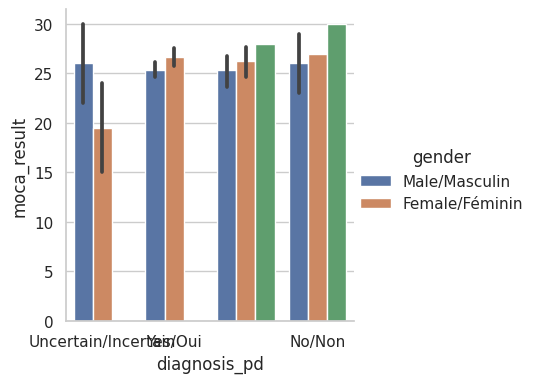

In [47]:
plot_df = qpn_df[qpn_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"].copy()

plot_col = "moca_result" #"updrs_score_part_3"
plot_df[plot_col] = plot_df[plot_col].replace("", np.nan)
plot_df[plot_col] = plot_df[plot_col].astype(float)
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    # kwargs = {'join':False, "marker":"d", "scale":1, "linewidth":0}
    g = sns.catplot(x="diagnosis_pd", y=plot_col, hue="gender", 
                kind="bar", height=4, aspect=1, data=plot_df, 
                # **kwargs
                )

### Detailed clinical scores

In [15]:
query_df = query_dict["MoCA-MDS-UPDRS part 3"]
query_df = query_df[query_df["record_id"].isin(common_participants)]
print(len(query_df))
query_df.head()

173


,record_id,redcap_event_name,enrolment_group_v2,moca_result,updrs_score_part_3,mds_updrs_h_y
51,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,25,26,"(1) Unilateral involvement only, usually with ..."
53,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,,28,(2) Bilateral involvement without impairment o...
54,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,26,22,(2) Bilateral involvement without impairment o...
58,MNI0109,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,30,7,"(1) Unilateral involvement only, usually with ..."
59,MNI0110,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,23,12,"(1) Unilateral involvement only, usually with ..."


In [16]:
query_df = query_dict["Victoria - Weston Project"]
query_df = query_df[query_df["record_id"].isin(common_participants)]
print(len(query_df))
query_df.head()

368


,record_id,redcap_event_name,gender,yrs_education,diagnosis_determined,duration_disease,symptom_asymmetry,current_asymmetry,moca_result_2,moca_result_3,...,moca_result_7,moca_result_8,moca_result_9,moca_result,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,mds_updrs_h_y,updrs_3b
122,MNI0056,Baseline (Arm 1: C-OPN),Male/Masculin,6,,6.1,Not Determined/Non déterminé,"Yes (both sides affected, one side affected mo...",2,3,...,2,3,6,22,12,22,58,0,(3) Bilateral disease: mild to moderate disabi...,ON: On is the typical functional state when pa...
124,MNI0058,Baseline (Arm 1: C-OPN),Male/Masculin,11,0,3.4,Right side/Côté droit,"Yes (both sides affected, one side affected mo...",4,3,...,0,4,6,25,0,6,26,0,"(1) Unilateral involvement only, usually with ...",ON: On is the typical functional state when pa...
129,MNI0068,Baseline (Arm 1: C-OPN),Male/Masculin,12,0,9.8,Left side/Côté gauche,"Yes (both sides affected, one side affected mo...",,,...,,,,,11,8,28,0,(2) Bilateral involvement without impairment o...,ON: On is the typical functional state when pa...
134,MNI0079,Baseline (Arm 1: C-OPN),Female/Féminin,20+,0,6.5,Both sides/Deux côtés,"Yes (both sides affected, one side affected mo...",2,3,...,2,5,6,26,13,10,22,8,(2) Bilateral involvement without impairment o...,ON: On is the typical functional state when pa...
135,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),,,,,,,,,...,,,,,,,,,,
